# Training A Neural Network for ASL Word Recognition

In sign language, words require motion. So in order to predict what word is being signed, the entire motion of the signer has to be taken into account. So using something like Conv2D will not work. To do this, a recursive neural network that has memoery should be used. The most popular one, and the one I found most information on was the LSTM (Long-Short Term Memory) layer. So, this is what I will be using in my neural network.

An LSTM layer can also return the output to be the input to the next LSTM layer. This is useful if more than one LSTM layer is used, which is usually the case. All LSTM layers in the network except for the last one, should have the ouputs chained to the input of the next layer.

## Collecting the Data That Was Pre-processed

Previously, I pre-processed the videos and generated landmark points and then saved them to a .npy file. I will now load all of these arrays into one 3 dimensional numpy array. The array will be of the shape: (number of videos, number of frames, number of landmark points)

In [1]:
import numpy as np
import os

However, I realized that I cannot make a numpy array that has different length dimensions at each dimension. For example, I can get 10 videos, but all 10 videos have to have the same number of frames. Otherwise, numpy would throw an error if for example: First video has 10 frames, second video has 15 frames, etc... So, I will have to crop the videos to be the same number of frames.

I will choose a frame number of 45, which is 1.8 seconds since every video is 25 frames per second. I think this should be good enough. To do the cropping, I will go through each video I created, and create a text file with the following structure:

```
<word_id>,<instance_id>,<start_frame>,<end_frame>
```

Then, I will read each line and split it based on the ',' character. The instance_id, start_frame, and end_frame will be in separate lists. Then I will loop through each instance and collect the frames in the range <start_frame> and <end_frame>

First, I created a sample text file with the following lines:

```
0,0,20,65
0,1,10,55
1,0,15,60
1,1,35,80

```

I will loop through these lines, and collect the numpy arrays in those directories: word_id 0 instance_id 0,1., and word_id 1 instance_id 0,1. Once I have a function that works, I will create the real text file and load all the numpy arrays

In [2]:
with open('train_frames_crop.txt', 'r') as f:
    lines = f.readlines()
# Remove the \n character at the end of each line
lines = [line[:-1] for line in lines]
print(lines)

['0,0,3,47', '0,1,8,52', '0,2,1,45', '0,3,15,59', '0,4,21,65', '0,5,44,88', '0,6,55,93', '0,7,58,100', '0,8,44,80', '0,9,1,31', '0,10,43,87', '0,11,40,77', '0,12,54,95', '0,13,38,75', '0,14,7,51', '0,15,11,55', '0,16,17,61', '0,17,1,18', '0,18,1,28', '0,19,1,33', '0,20,1,33', '0,21,16,60', '0,22,16,60', '0,23,69,99', '0,24,38,79', '0,25,57,93', '0,26,64,104', '0,27,39,75', '0,28,47,82', '0,29,47,80', '1,0,1,45', '1,1,1,45', '1,2,11,55', '1,3,11,55', '1,4,15,59', '1,5,5,49', '1,6,10,54', '1,7,8,52', '1,8,13,57', '1,9,13,57', '1,10,10,54', '1,11,14,58', '1,12,1,45', '1,13,16,60', '1,14,1,38', '1,15,1,45', '1,16,1,45', '1,17,1,45', '1,18,23,67', '1,19,1,37', '1,20,4,48', '1,21,1,35', '1,22,1,42', '1,23,1,42', '1,24,7,51', '2,0,20,64', '2,1,14,58', '2,2,20,64', '2,3,26,70', '2,4,31,75', '2,5,13,57', '2,6,15,59', '2,7,22,66', '2,8,15,59', '2,9,18,62', '2,10,1,38', '2,11,1,38', '2,12,1,45', '2,13,1,39', '2,14,1,35', '2,15,10,54', '2,16,5,49', '2,17,1,45', '2,18,12,56', '2,19,1,40', '3,0,1,41

In [52]:
train_data = []
for i in range(len(lines)):
    vid_data = []

    line_split = lines[i].split(',')
    word_id = line_split[0]
    instance_id = line_split[1]
    start_frame = line_split[2]
    end_frame = line_split[3]
    extra_frames = 44 - (int(end_frame) - int(start_frame))
    print(word_id)
    print(instance_id)
    print(start_frame)
    print(end_frame)
    path_to_npy_dir = os.path.join('train',word_id,instance_id,'points_arrays')
    for frame in range(int(start_frame), int(end_frame)+1):
        path_to_npy = os.path.join(path_to_npy_dir, f'{instance_id}_{str(frame)}.npy')
        frame_array = np.load(path_to_npy)
        print(f'loaded {path_to_npy}')
        vid_data.append(frame_array)
        # If the video has less than 45 frames, I will copy each frame more than once until there are exactly 45 frames
        if extra_frames > 0:
            vid_data.append(frame_array)
            print(f'Loaded Extra {path_to_npy}')
            extra_frames -= 1
        #print(path_to_npy)
    train_data.append(vid_data)
print(np.array(train_data).shape)

0
0
19
63
loaded train/0/0/points_arrays/0_19.npy
loaded train/0/0/points_arrays/0_20.npy
loaded train/0/0/points_arrays/0_21.npy
loaded train/0/0/points_arrays/0_22.npy
loaded train/0/0/points_arrays/0_23.npy
loaded train/0/0/points_arrays/0_24.npy
loaded train/0/0/points_arrays/0_25.npy
loaded train/0/0/points_arrays/0_26.npy
loaded train/0/0/points_arrays/0_27.npy
loaded train/0/0/points_arrays/0_28.npy
loaded train/0/0/points_arrays/0_29.npy
loaded train/0/0/points_arrays/0_30.npy
loaded train/0/0/points_arrays/0_31.npy
loaded train/0/0/points_arrays/0_32.npy
loaded train/0/0/points_arrays/0_33.npy
loaded train/0/0/points_arrays/0_34.npy
loaded train/0/0/points_arrays/0_35.npy
loaded train/0/0/points_arrays/0_36.npy
loaded train/0/0/points_arrays/0_37.npy
loaded train/0/0/points_arrays/0_38.npy
loaded train/0/0/points_arrays/0_39.npy
loaded train/0/0/points_arrays/0_40.npy
loaded train/0/0/points_arrays/0_41.npy
loaded train/0/0/points_arrays/0_42.npy
loaded train/0/0/points_arrays

As shown here, there are 4 videos, each having 45 frames, each frame having 1662 landmark points

Incase a video has less than 45 frames, I will append each numpy array more than once depending on how many times are needed to reach 45 frames. I might also not need to do this for every frame. For example, if a video has 40 frames, I will only append the first 5 frames twice. This can make some videos look more slow-motion than others, but it should not affect the quality of the training

Now, I will make this into a function

In [3]:
def collect_data_arrays(split_type='train', crop_file='train_frames_crop.txt', num_frames=45):
    with open(crop_file, 'r') as f:
        lines = f.readlines()
    # Remove the \n character at the end of each line
    lines = [line[:-1] for line in lines]
    print(lines)

    train_data = []
    train_labels = []
    for i in range(len(lines)):
        vid_data = []
        line_split = lines[i].split(',')
        word_id = line_split[0]
        instance_id = line_split[1]
        start_frame = line_split[2]
        end_frame = line_split[3]
        vid_frame_num = int(end_frame) - int(start_frame) + 1
        extra_frames = (num_frames) - vid_frame_num
        if (vid_frame_num != 45):
            print(f'{i} has {extra_frames} extra frames')
        if extra_frames > vid_frame_num:
            quotient = extra_frames//vid_frame_num
            remainder = extra_frames%vid_frame_num
        else:
            quotient = 0
            remainder = extra_frames
        print(f'extra {quotient} of each frame, and one more of start of frames to {remainder}')
        #print(word_id)
        #print(instance_id)
        #print(start_frame)
        #print(end_frame)
        path_to_npy_dir = os.path.join(split_type, word_id, instance_id, 'points_arrays')
        for frame in range(int(start_frame), int(end_frame)+1):
            path_to_npy = os.path.join(path_to_npy_dir, f'{instance_id}_{str(frame)}.npy')
            frame_array = np.load(path_to_npy)
            print(f'loaded {path_to_npy}')
            vid_data.append(frame_array)
            # If the video has less than 45 frames, I will copy each frame more than once until there are exactly 45 frames
            if extra_frames > 0:
                for i in range(quotient):
                    vid_data.append(frame_array)
                print(f'Loaded extra {quotient} {path_to_npy}')
                if remainder > 0:
                    vid_data.append(frame_array)
                    remainder -= 1
                    print(f'Loaded one more {path_to_npy}')
            # if extra_frames > 2*(vid_frame_num - (int(end_frame) - frame)):
            #     vid_data.append(frame_array)
            #     vid_data.append(frame_array)
            #     vid_data.append(frame_array)
            #     print(f'Loaded 3 Extra {path_to_npy}: {extra_frames}, {2*(vid_frame_num - (int(end_frame) - frame))}')
            #     extra_frames -= 3
            # elif extra_frames > (vid_frame_num - (int(end_frame) - frame)):
            #     vid_data.append(frame_array)
            #     vid_data.append(frame_array)
            #     print(f'Loaded 2 Extra {path_to_npy}: {extra_frames}, {(vid_frame_num - (int(end_frame) - frame))}')
            #     extra_frames -= 2
            # elif extra_frames > 0:
            #     vid_data.append(frame_array)
            #     print(f'Loaded Extra {path_to_npy}')
            #     extra_frames -= 1
            #print(path_to_npy)
        if len(vid_data) != 45:
            print(f"Not 45 frames, {extra_frames}, {len(vid_data)}, {vid_frame_num}")
        train_data.append(vid_data)
        train_labels.append(word_id)
        #print(train_data)
    print(np.array(train_data).shape)
    return np.array(train_data), np.array(train_labels)

I will now test this function

In [4]:
train_dataset, train_labels = collect_data_arrays() #Using default values. Train split, 'train_frames_crop.txt' file, and 45 frames

['0,0,3,47', '0,1,8,52', '0,2,1,45', '0,3,15,59', '0,4,21,65', '0,5,44,88', '0,6,55,93', '0,7,58,100', '0,8,44,80', '0,9,1,31', '0,10,43,87', '0,11,40,77', '0,12,54,95', '0,13,38,75', '0,14,7,51', '0,15,11,55', '0,16,17,61', '0,17,1,18', '0,18,1,28', '0,19,1,33', '0,20,1,33', '0,21,16,60', '0,22,16,60', '0,23,69,99', '0,24,38,79', '0,25,57,93', '0,26,64,104', '0,27,39,75', '0,28,47,82', '0,29,47,80', '1,0,1,45', '1,1,1,45', '1,2,11,55', '1,3,11,55', '1,4,15,59', '1,5,5,49', '1,6,10,54', '1,7,8,52', '1,8,13,57', '1,9,13,57', '1,10,10,54', '1,11,14,58', '1,12,1,45', '1,13,16,60', '1,14,1,38', '1,15,1,45', '1,16,1,45', '1,17,1,45', '1,18,23,67', '1,19,1,37', '1,20,4,48', '1,21,1,35', '1,22,1,42', '1,23,1,42', '1,24,7,51', '2,0,20,64', '2,1,14,58', '2,2,20,64', '2,3,26,70', '2,4,31,75', '2,5,13,57', '2,6,15,59', '2,7,22,66', '2,8,15,59', '2,9,18,62', '2,10,1,38', '2,11,1,38', '2,12,1,45', '2,13,1,39', '2,14,1,35', '2,15,10,54', '2,16,5,49', '2,17,1,45', '2,18,12,56', '2,19,1,40', '3,0,1,41

In [5]:
print(train_labels)

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3'
 '3' '3' '3' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5'
 '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '6' '6' '6' '6' '6' '6' '6' '6'
 '6' '6' '6' '6' '6' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7'
 '7' '7' '7' '7' '7' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8'
 '8' '8' '8' '8' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9'
 '9' '9']


I don't need to make the labels actual words, I can do that during the prediction phase using the txt file that has all the word_ids and what word they correspond to

This function is working now, and I can get numpy arrays of 45 frames for all my videos. So, I will now go through each video (~250 for 10 words and 3 split types) and create the text file. This should not take long since each video is on average around 3 seconds

Getting the training data

In [6]:
train_data, train_label = collect_data_arrays()

['0,0,3,47', '0,1,8,52', '0,2,1,45', '0,3,15,59', '0,4,21,65', '0,5,44,88', '0,6,55,93', '0,7,58,100', '0,8,44,80', '0,9,1,31', '0,10,43,87', '0,11,40,77', '0,12,54,95', '0,13,38,75', '0,14,7,51', '0,15,11,55', '0,16,17,61', '0,17,1,18', '0,18,1,28', '0,19,1,33', '0,20,1,33', '0,21,16,60', '0,22,16,60', '0,23,69,99', '0,24,38,79', '0,25,57,93', '0,26,64,104', '0,27,39,75', '0,28,47,82', '0,29,47,80', '1,0,1,45', '1,1,1,45', '1,2,11,55', '1,3,11,55', '1,4,15,59', '1,5,5,49', '1,6,10,54', '1,7,8,52', '1,8,13,57', '1,9,13,57', '1,10,10,54', '1,11,14,58', '1,12,1,45', '1,13,16,60', '1,14,1,38', '1,15,1,45', '1,16,1,45', '1,17,1,45', '1,18,23,67', '1,19,1,37', '1,20,4,48', '1,21,1,35', '1,22,1,42', '1,23,1,42', '1,24,7,51', '2,0,20,64', '2,1,14,58', '2,2,20,64', '2,3,26,70', '2,4,31,75', '2,5,13,57', '2,6,15,59', '2,7,22,66', '2,8,15,59', '2,9,18,62', '2,10,1,38', '2,11,1,38', '2,12,1,45', '2,13,1,39', '2,14,1,35', '2,15,10,54', '2,16,5,49', '2,17,1,45', '2,18,12,56', '2,19,1,40', '3,0,1,41

In [7]:
print(train_data.shape)

(200, 45, 1662)


This means that there are 200 videos for training, with each video having 45 frames. Each frame has 1662 landmark points

In [8]:
print(train_label.shape)
print(train_label)

(200,)
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3'
 '3' '3' '3' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5'
 '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '6' '6' '6' '6' '6' '6' '6' '6'
 '6' '6' '6' '6' '6' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7'
 '7' '7' '7' '7' '7' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8' '8'
 '8' '8' '8' '8' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9' '9'
 '9' '9']


Each video has its own label. But many are repeated since multiple videos are taken for each sign

Next, I will repeat this for validation and testing datasets. Then I will be ready to create the network and train it

In [9]:
test_data, test_label = collect_data_arrays(split_type='test', crop_file='test_frames_crop.txt')

['0,0,40,74', '0,1,44,78', '0,2,48,78', '0,3,1,18', '1,0,19,63', '1,1,17,61', '1,2,12,50', '1,3,14,57', '2,0,1,45', '2,1,10,54', '2,2,12,56', '2,3,23,67', '2,4,1,36', '3,0,1,45', '3,1,15,59', '3,2,1,44', '3,3,1,28', '4,0,1,45', '4,1,10,40', '4,2,14,58', '5,0,1,35', '5,1,1,39', '5,2,3,40', '6,0,1,45', '6,1,18,62', '6,2,75,115', '7,0,1,45', '7,1,5,45', '7,2,1,45', '8,0,8,52', '8,1,13,47', '8,2,1,36', '9,0,18,52', '9,1,20,64', '9,2,10,44']
0 has 10 extra frames
extra 0 of each frame, and one more of start of frames to 10
loaded test/0/0/points_arrays/0_40.npy
Loaded extra 0 test/0/0/points_arrays/0_40.npy
Loaded one more test/0/0/points_arrays/0_40.npy
loaded test/0/0/points_arrays/0_41.npy
Loaded extra 0 test/0/0/points_arrays/0_41.npy
Loaded one more test/0/0/points_arrays/0_41.npy
loaded test/0/0/points_arrays/0_42.npy
Loaded extra 0 test/0/0/points_arrays/0_42.npy
Loaded one more test/0/0/points_arrays/0_42.npy
loaded test/0/0/points_arrays/0_43.npy
Loaded extra 0 test/0/0/points_arra

In [10]:
print(test_data.shape)

(35, 45, 1662)


The test directory has 35 videos in total for 10 words. Each video is 45 frames. Each frame has 1662 landmark points

In [11]:
print(test_label.shape)
print(test_label)

(35,)
['0' '0' '0' '0' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3' '3' '3' '3' '4'
 '4' '4' '5' '5' '5' '6' '6' '6' '7' '7' '7' '8' '8' '8' '9' '9' '9']


Finally, for the validation dataset:

In [12]:
val_data, val_label = collect_data_arrays(split_type='val', crop_file='val_frames_crop.txt')

['0,0,17,61', '0,1,50,80', '0,2,40,75', '0,3,52,89', '0,4,20,54', '0,5,58,89', '1,0,10,54', '1,1,39,75', '1,2,18,62', '1,3,15,59', '1,4,14,58', '1,5,1,26', '2,0,34,77', '2,1,5,49', '2,2,13,55', '2,3,3,47', '2,4,10,54', '3,0,1,42', '3,1,25,60', '3,2,1,12', '3,3,5,49', '4,0,22,66', '4,1,1,27', '4,2,1,27', '4,3,10,54', '5,0,8,52', '5,1,1,34', '5,2,1,18', '5,3,1,29', '6,0,14,44', '6,1,16,60', '6,2,52,88', '6,3,36,75', '7,0,10,41', '7,1,8,40', '7,2,18,50', '7,3,1,39', '8,0,12,52', '8,1,1,27', '8,2,1,33', '8,3,1,43', '9,0,25,69', '9,1,15,59', '9,2,1,32', '9,3,1,38']
extra 0 of each frame, and one more of start of frames to 0
loaded val/0/0/points_arrays/0_17.npy
loaded val/0/0/points_arrays/0_18.npy
loaded val/0/0/points_arrays/0_19.npy
loaded val/0/0/points_arrays/0_20.npy
loaded val/0/0/points_arrays/0_21.npy
loaded val/0/0/points_arrays/0_22.npy
loaded val/0/0/points_arrays/0_23.npy
loaded val/0/0/points_arrays/0_24.npy
loaded val/0/0/points_arrays/0_25.npy
loaded val/0/0/points_arrays/0_

In [13]:
print(val_data.shape)

(45, 45, 1662)


So, the validation dataset has 45 videos, each video has 45 frames, and each frame has 1662 landmark points

In [14]:
print(val_label.shape)
print(val_label)

(45,)
['0' '0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3'
 '3' '3' '3' '4' '4' '4' '4' '5' '5' '5' '5' '6' '6' '6' '6' '7' '7' '7'
 '7' '8' '8' '8' '8' '9' '9' '9' '9']


## Training

Now that I have training dataset, validation dataset, and test dataset, I can begin constructing the neural network and training the model

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, RandomZoom, RandomRotation
from tensorflow.keras.utils import to_categorical

2024-12-10 21:27:48.131335: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 21:27:48.139362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 21:27:48.209406: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 21:27:48.271969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733884068.327365    7268 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733884068.34

In [124]:
model_inputs = Input(shape=(45,1662))
x = LSTM(16, return_sequences=True, activation='relu')(model_inputs)
x = LSTM(32, return_sequences=True, activation='relu')(x)
x = LSTM(32, return_sequences=False, activation='relu')(x)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
model_outputs = Dense(10, activation='softmax')(x)

In [17]:
model = Sequential([
    LSTM(32, return_sequences=True, activation='relu', input_shape=(45,1662)),
    LSTM(64, return_sequences=True, activation='relu'),
    LSTM(32, return_sequences=False, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

W0000 00:00:1733884071.511121    7268 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/hadiml/anaconda3/envs/ece5831-2024/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 45, 32)         │       216,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 45, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,890 (1.00 MB)

 Trainable params: 262,890 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
print(train_label.shape)
print(train_data.shape)
train_label_cat = to_categorical(train_label)

test_label_cat = to_categorical(test_label)

val_label_cat = to_categorical(val_label)

(200,)
(200, 45, 1662)


In [21]:
history = model.fit(train_data, train_label_cat, epochs=500, batch_size=16, validation_data=(val_data, val_label_cat))

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1218 - loss: 417.7532 - val_accuracy: 0.0889 - val_loss: 2.2994
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1117 - loss: 2.3676 - val_accuracy: 0.1556 - val_loss: 2.6342
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1368 - loss: 2.5467 - val_accuracy: 0.1333 - val_loss: 5.6493
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1112 - loss: 29.6243 - val_accuracy: 0.1333 - val_loss: 41.3883
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1198 - loss: 42.0005 - val_accuracy: 0.0889 - val_loss: 17.0356
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2147 - loss: 5.5874 - val_accuracy: 0.0889 - val_loss: 2.3200
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0665 - loss: 2.3360 - val_accuracy: 0.1333 - val_loss: 2.2903
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1039 - loss: 2.3328 - val_accura

In [22]:
model.save('asl_model_0.2955.keras')

In [23]:
import matplotlib.pyplot as plt

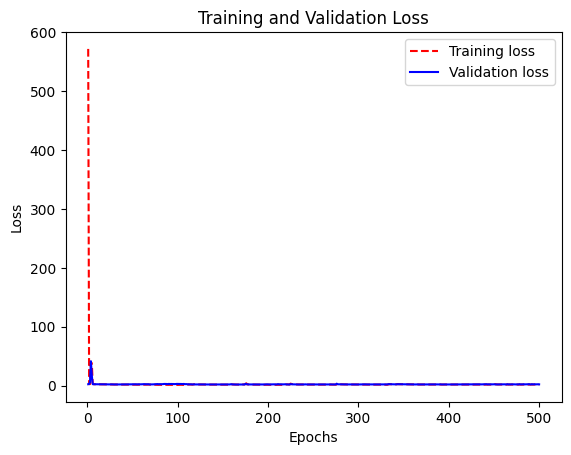

In [30]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r--", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


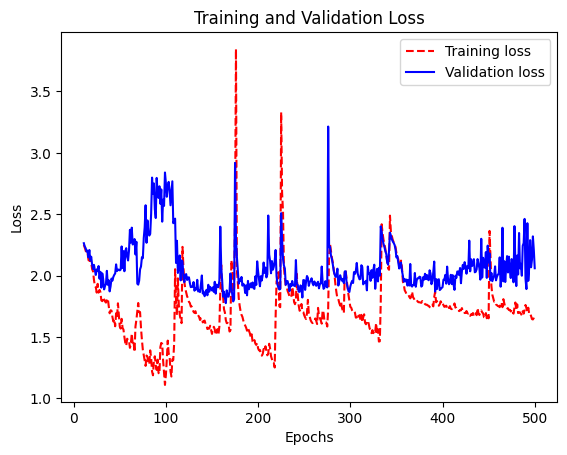

In [31]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs[10:], loss_values[10:], "r--", label="Training loss")
plt.plot(epochs[10:], val_loss_values[10:], "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


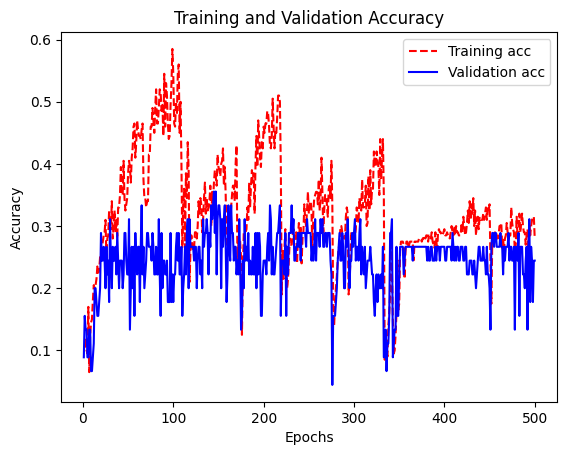

In [32]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [33]:
model.evaluate(test_data, test_label_cat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2062 - loss: 2.2134 


[2.2010488510131836, 0.20000000298023224]

This is very bad accuracy

I will be trying to create my own dataset to see if that is a better option than using this Kaggle dataset